# Ola Bangalore Efficiency Analysis & Customer Experience Enhancement

## Section 0: Basic Setup

In [66]:
# 0a. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 0b. Set seaborn style
sns.set_style('whitegrid')

In [25]:
# Load dataset
try:
    df = pd.read_csv('Bengaluru_Ola_Booking_Data.csv')
    print("Dataset loaded successfully.")

except FileNotFoundError:
    print("Error: Dataset not found. Please ensure 'Bengaluru_Ola_Booking_Data.csv' is in the working directory.")

Dataset loaded successfully.


In [26]:
df.head()

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for Cancelling by Customer,Cancelled Rides by Driver,Reason for Cancelling by Driver,Incomplete Rides,Incomplete Rides Reason,Booking Value,Payment Method,Ride Distance,Driver Ratings,Customer Rating
0,2024-01-28,06:00:00,CNR1721175,Success,329258,Auto,Area-3,Area-2,5.42,18.46,...,NaN,0,NaN,0,NaN,868.06,Wallet,28.5,4.4,4.4
1,2024-01-26,03:00:00,CNR2871422,Cancelled by Driver,201414,Mini,Area-7,Area-6,NaN,NaN,...,NaN,1,The customer was coughing/sick,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-15,16:00:00,CNR6875935,Cancelled by Driver,301629,Bike,Area-40,Area-24,NaN,NaN,...,NaN,1,Personal & Car related issues,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-02,22:00:00,CNR6798834,Cancelled by Driver,319684,Prime Sedan,Area-11,Area-24,NaN,NaN,...,NaN,1,The customer was coughing/sick,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-30,22:00:00,CNR9661713,Incomplete,330283,Bike,Area-41,Area-45,NaN,NaN,...,NaN,0,NaN,1,Other Issue,NaN,NaN,NaN,NaN,NaN


In [27]:
df.shape

(50000, 21)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               50000 non-null  object 
 1   Time                               50000 non-null  object 
 2   Booking ID                         50000 non-null  object 
 3   Booking Status                     50000 non-null  object 
 4   Customer ID                        50000 non-null  int64  
 5   Vehicle Type                       50000 non-null  object 
 6   Pickup Location                    50000 non-null  object 
 7   Drop Location                      50000 non-null  object 
 8   Avg VTAT                           33484 non-null  float64
 9   Avg CTAT                           33484 non-null  float64
 10  Cancelled Rides by Customer        50000 non-null  int64  
 11  Reason for Cancelling by Customer  3800 non-null   obj

In [29]:
# Selecting key numerical columns
stats_cols = ['Avg VTAT', 'Avg CTAT', 'Booking Value', 'Ride Distance', 'Driver Ratings', 'Customer Rating']
desc_stats = df[stats_cols].describe().T

# Adding Median and IQR
desc_stats['median'] = df[stats_cols].median()
desc_stats['IQR'] = desc_stats['75%'] - desc_stats['25%']

final_desc_table = desc_stats[['count', 'mean', 'median', 'std', 'min', 'max', '25%', '75%', 'IQR']]

print("Table 1: Descriptive Statistics for Numerical Features")
final_desc_table.round(2)
final_desc_table.to_excel("descriptive_stats.xlsx", index=True)


Table 1: Descriptive Statistics for Numerical Features


In [30]:
# Converting Date and Time to datetime datatype
# Some dates might be ambiguous, so we coerce errors
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
# Combine Date and Time into a single 'Timestamp' column

# Ensure Time is string before combining ( so that NaNs are handled properly)
df['Timestamp'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str), errors='coerce')

# Drop rows with invalid Timestamp
df.dropna(subset=['Timestamp'], inplace=True)

# Create Time-based features
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.day_name()
df['Is_Weekend'] = df['Timestamp'].dt.dayofweek >= 5

# Peak Hour Flag (Morning: 8-11, Evening: 17-21)
df['Peak_Hour'] = df['Hour'].apply(lambda x: 1 if (8 <= x <= 11) or (17 <= x <= 21) else 0)

# Handle Missing Values
# For categorical cancellation reasons, fill with 'Not Cancelled'
fill_cols = ['Reason for Cancelling by Customer', 'Reason for Cancelling by Driver', 'Incomplete Rides Reason']
for col in fill_cols:
    if col in df.columns:
        df[col] = df[col].fillna('Not Cancelled')

# Create Target Variable for Classification
# Success = 1, Others = 0
df['Is_Success'] = (df['Booking Status'] == 'Success').astype(int)

# Encode Categorical Variables for Modeling
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# Label Encoding for high cardinality
label_cols = ['Pickup Location', 'Drop Location']
for col in label_cols:
    df[col] = df[col].astype(str).fillna('Unknown')
    df[f'{col}_Encoded'] = le.fit_transform(df[col])

# One-Hot Encoding for low cardinality (Vehicle Type, Payment Method, DayOfWeek)
# We will do this via get_dummies later or manually map if needed for trees, 
# but for now let's stick to Label Encoding for simplicity in this script, 
# or add One-Hot if we want to be more precise for Linear Models.
# Let's add Label Encoding for these too for Tree models.
cat_cols = ['Vehicle Type', 'Payment Method', 'DayOfWeek']
for col in cat_cols:
    df[col] = df[col].astype(str).fillna('Unknown')
    df[f'{col}_Encoded'] = le.fit_transform(df[col])

print("Data Cleaning and Feature Engineering Completed.")
print(df[['Timestamp', 'Hour', 'Peak_Hour', 'Is_Success']].head())

print(df.shape)

Data Cleaning and Feature Engineering Completed.
            Timestamp  Hour  Peak_Hour  Is_Success
0 2024-01-28 06:00:00     6          0           1
1 2024-01-26 03:00:00     3          0           0
2 2024-01-15 16:00:00    16          0           0
3 2024-01-02 22:00:00    22          0           0
4 2024-01-30 22:00:00    22          0           0
(50000, 32)


## Additional EDA: Demand and Status Visualizations
Let's visualize booking patterns and status distributions from the cleaned data.

C:\Users\Sarang\AppData\Local\Temp\ipykernel_9812\678454391.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Hour', palette='viridis')


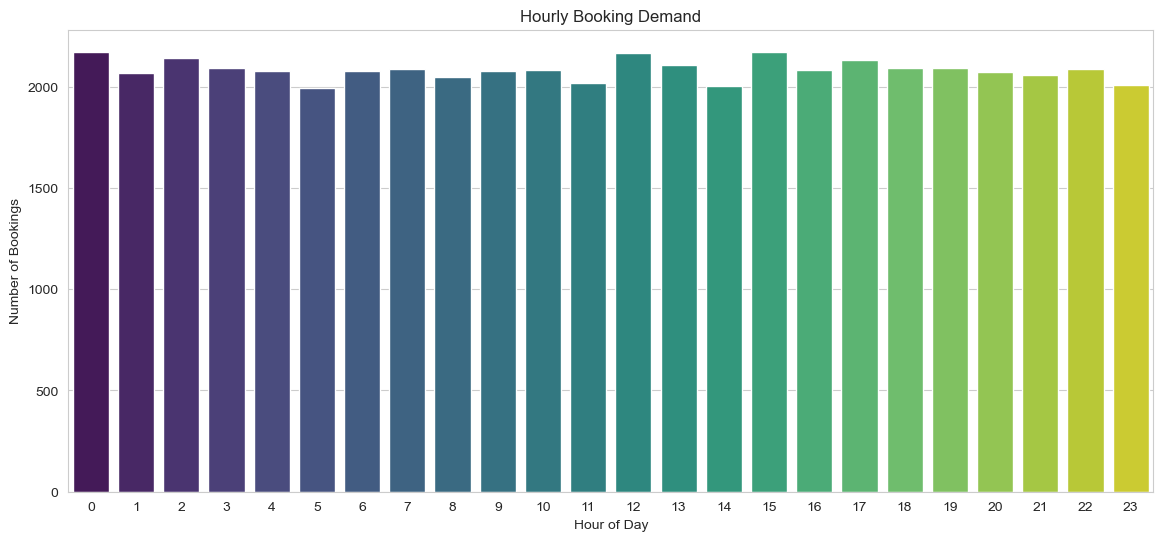

C:\Users\Sarang\AppData\Local\Temp\ipykernel_9812\678454391.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='DayOfWeek', order=order, palette='magma')


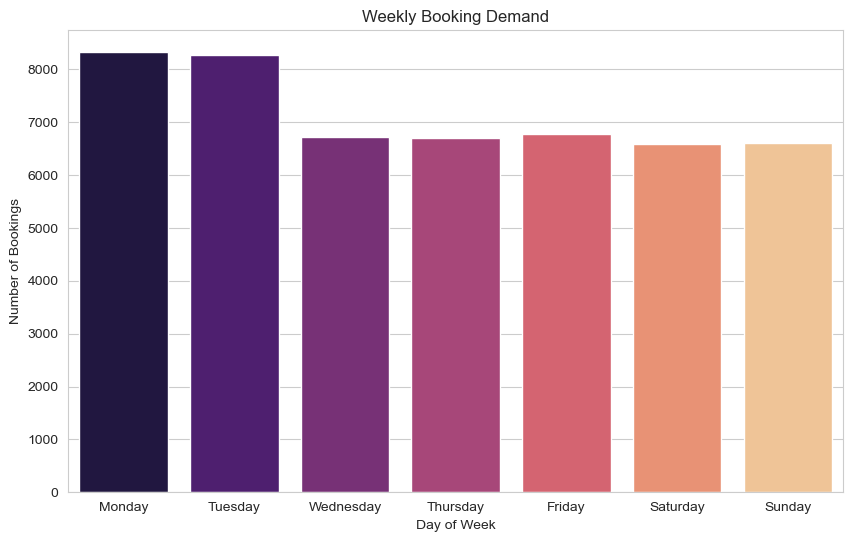

In [31]:
# Hourly Demand
plt.figure(figsize=(14, 6))
sns.countplot(data=df, x='Hour', palette='viridis')
plt.title('Hourly Booking Demand')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Bookings')
plt.show()

# Weekly Demand
plt.figure(figsize=(10, 6))
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=df, x='DayOfWeek', order=order, palette='magma')
plt.title('Weekly Booking Demand')
plt.xlabel('Day of Week')
plt.ylabel('Number of Bookings')
plt.show()

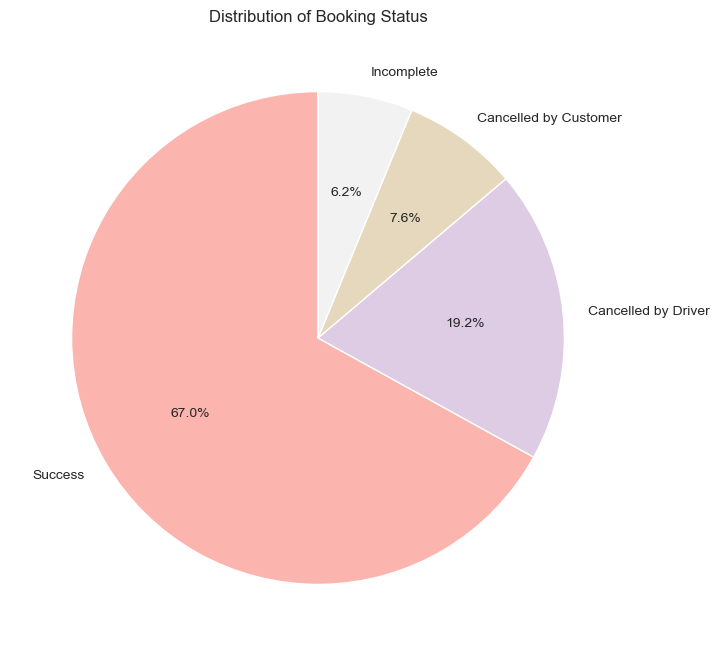

In [32]:
# Booking Status Distribution
plt.figure(figsize=(8, 8))
df['Booking Status'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Pastel1')
plt.title('Distribution of Booking Status')
plt.ylabel('')
plt.show()

C:\Users\Sarang\AppData\Local\Temp\ipykernel_9812\3946516688.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_pickup.index, x=top_pickup.values, palette='cool')


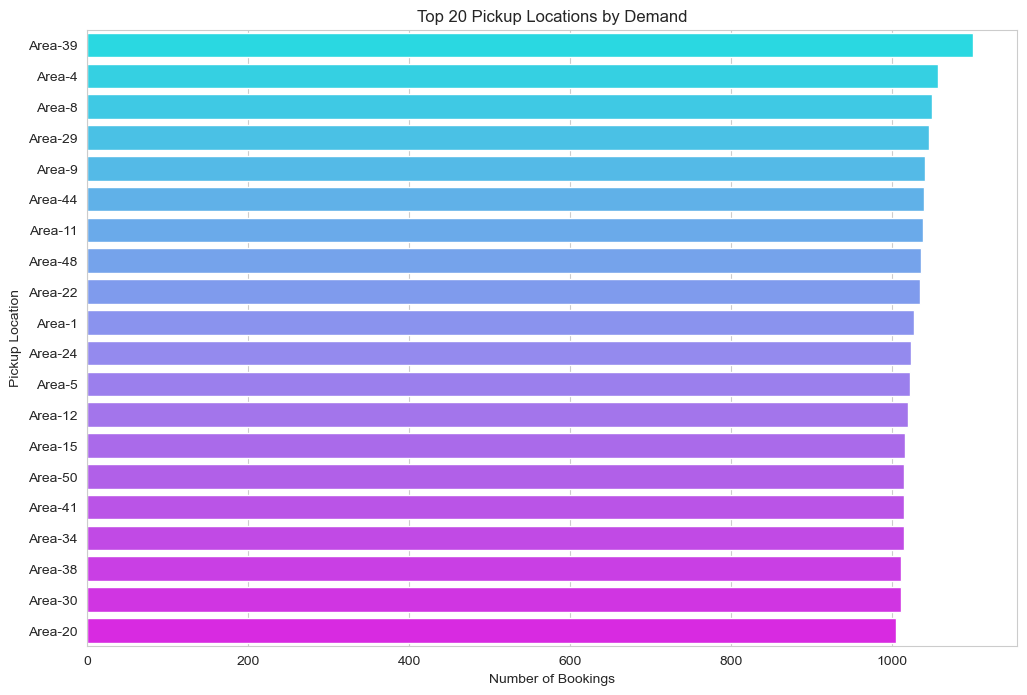

In [33]:
# Demand by Pickup Location (Top 20)
top_pickup = df['Pickup Location'].value_counts().head(20)
plt.figure(figsize=(12, 8))
sns.barplot(y=top_pickup.index, x=top_pickup.values, palette='cool')
plt.title('Top 20 Pickup Locations by Demand')
plt.xlabel('Number of Bookings')
plt.show()

## Section 1: Problem 1 - Cancellations & Driver Earnings Volatility
**Objective:** Understand how ride cancellations and incomplete trips affect drivers' earning stability across time, areas, and vehicle types in Ola Bangalore.

In [34]:
print("\n### Problem 1: Cancellations & Driver Earnings Volatility")

# Note: Hour column already created in preprocessing above

# a. Create subsets
completed = df[df['Booking Status'] == 'Success'].copy()
non_completed = df[df['Booking Status'] != 'Success'].copy()

# Create 'Driver_Earning_Proxy' = 'Booking Value'
completed['Driver_Earning_Proxy'] = completed['Booking Value']



### Problem 1: Cancellations & Driver Earnings Volatility


In [35]:

# b. Earnings volatility by area and hour
earnings_area_hour = completed.groupby(['Pickup Location', 'Hour'])['Driver_Earning_Proxy'].agg(
    trip_count='count',
    mean_earning='mean',
    std_earning='std'
).reset_index()

# Build area_vol
area_vol = earnings_area_hour.groupby('Pickup Location').agg(
    Mean_Earning=('mean_earning', 'mean'),
    Earning_Volatility=('std_earning', 'mean')
).reset_index()


In [36]:

# d. Cancellation rates
# Cancellation_Rate_Area
total_rides_area = df.groupby('Pickup Location').size()
cancelled_rides_area = non_completed.groupby('Pickup Location').size()
cancellation_rates_area = (cancelled_rides_area / total_rides_area).fillna(0).reset_index(name='Cancellation_Rate_Area')

In [37]:
# Cancellation_Rate_Hour
total_rides_hour = df.groupby('Hour').size()
cancelled_rides_hour = non_completed.groupby('Hour').size()
cancellation_rates_hour = (cancelled_rides_hour / total_rides_hour).fillna(0).reset_index(name='Cancellation_Rate_Hour')


In [38]:
# e. Merge for area-level summary
area_summary = pd.merge(area_vol, cancellation_rates_area, on='Pickup Location', how='inner')

C:\Users\Sarang\AppData\Local\Temp\ipykernel_9812\243377572.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Hour', y='Cancellation_Rate_Hour', data=cancellation_rates_hour, palette='viridis')


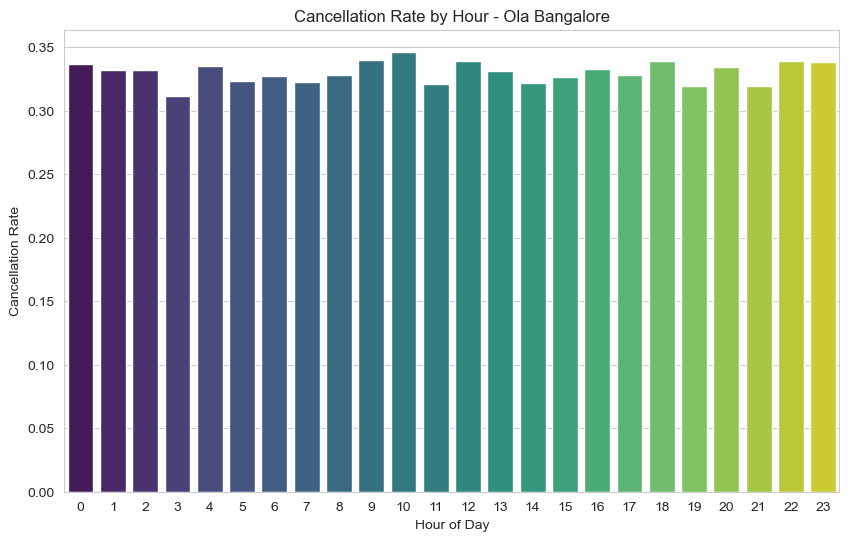

In [39]:

# f. Visualizations
plt.figure(figsize=(10, 6))
sns.barplot(x='Hour', y='Cancellation_Rate_Hour', data=cancellation_rates_hour, palette='viridis')
plt.title('Cancellation Rate by Hour - Ola Bangalore')
plt.ylabel('Cancellation Rate')
plt.xlabel('Hour of Day')
plt.show()


C:\Users\Sarang\AppData\Local\Temp\ipykernel_9812\412928654.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cancellation_Rate_Area', y='Pickup Location', data=top_n_cancel, palette='Reds_r')


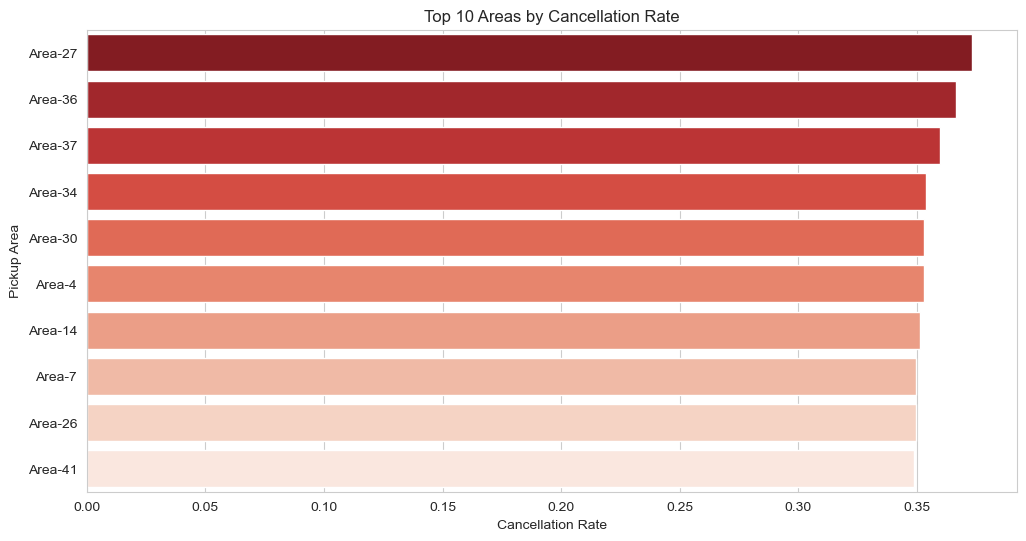

In [40]:

# Top N areas by Cancellation Rate
top_n_cancel = cancellation_rates_area.sort_values('Cancellation_Rate_Area', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='Cancellation_Rate_Area', y='Pickup Location', data=top_n_cancel, palette='Reds_r')
plt.title('Top 10 Areas by Cancellation Rate')
plt.xlabel('Cancellation Rate')
plt.ylabel('Pickup Area')
plt.show()


C:\Users\Sarang\AppData\Local\Temp\ipykernel_9812\3679646568.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Earning_Volatility', y='Pickup Location', data=top_n_vol, palette='Oranges_r')


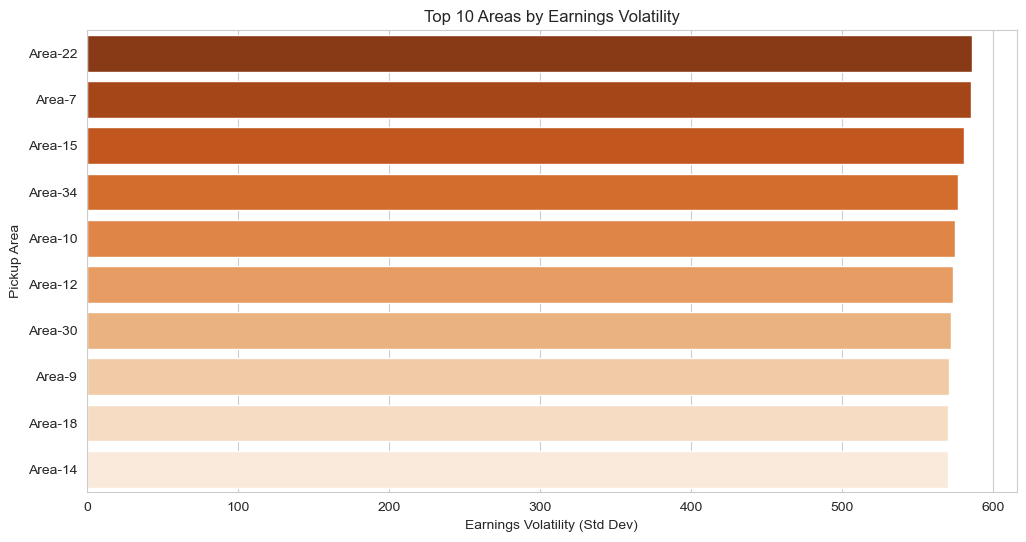

In [41]:

# Earning Volatility for Top N Areas (by volatility)
top_n_vol = area_vol.sort_values('Earning_Volatility', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='Earning_Volatility', y='Pickup Location', data=top_n_vol, palette='Oranges_r')
plt.title('Top 10 Areas by Earnings Volatility')
plt.xlabel('Earnings Volatility (Std Dev)')
plt.ylabel('Pickup Area')
plt.show()


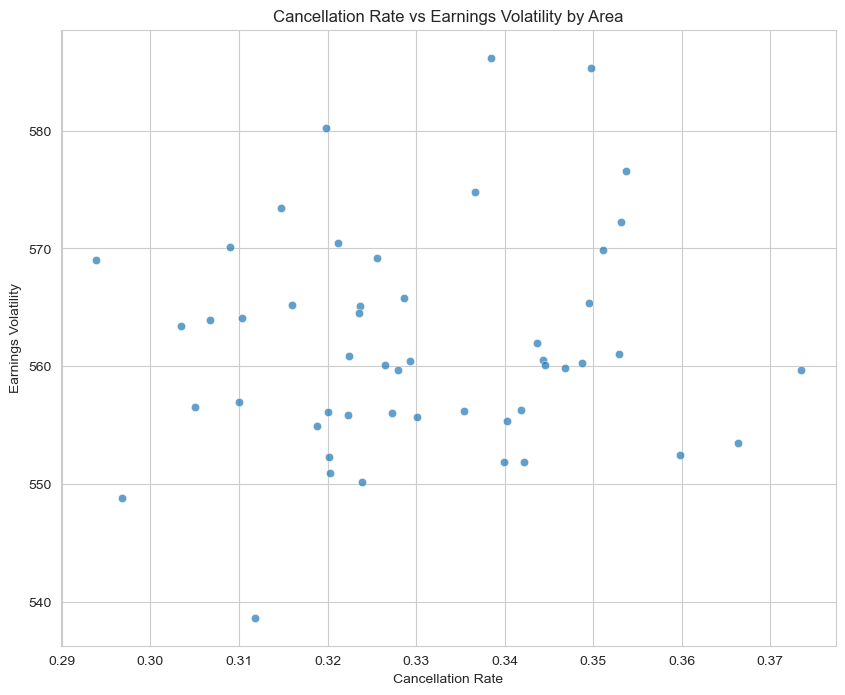

In [42]:

# Scatter: Cancellation Rate vs Earning Volatility
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Cancellation_Rate_Area', y='Earning_Volatility', data=area_summary, alpha=0.7)
plt.title('Cancellation Rate vs Earnings Volatility by Area')
plt.xlabel('Cancellation Rate')
plt.ylabel('Earnings Volatility')
plt.show()


C:\Users\Sarang\AppData\Local\Temp\ipykernel_9812\1920239409.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Area_Type', y='Driver_Earning_Proxy', data=completed, palette='Set2')


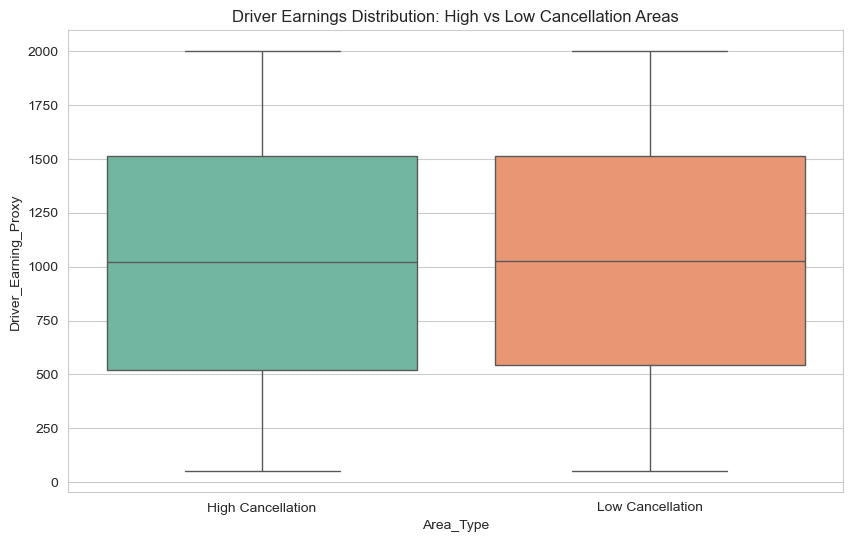

In [43]:

# Boxplot: Driver Earnings for High vs Low Cancellation Areas
median_cancel_rate = area_summary['Cancellation_Rate_Area'].median()
high_cancel_areas = area_summary[area_summary['Cancellation_Rate_Area'] > median_cancel_rate]['Pickup Location']
completed['Area_Type'] = completed['Pickup Location'].apply(lambda x: 'High Cancellation' if x in high_cancel_areas.values else 'Low Cancellation')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Area_Type', y='Driver_Earning_Proxy', data=completed, palette='Set2')
plt.title('Driver Earnings Distribution: High vs Low Cancellation Areas')
plt.show()


In [44]:

# g. Numeric Summaries
print("\nTop 5 Areas by Cancellation Rate:")
print(top_n_cancel.head(5))
print("\nTop 5 Areas by Earnings Volatility:")
print(top_n_vol.head(5))

corr = area_summary['Cancellation_Rate_Area'].corr(area_summary['Earning_Volatility'])
print(f"\nCorrelation between Cancellation Rate and Earnings Volatility: {corr:.2f}")



Top 5 Areas by Cancellation Rate:
   Pickup Location  Cancellation_Rate_Area
19         Area-27                0.373431
29         Area-36                0.366357
30         Area-37                0.359788
27         Area-34                0.353695
23         Area-30                0.353116

Top 5 Areas by Earnings Volatility:
   Pickup Location  Mean_Earning  Earning_Volatility
14         Area-22   1044.352619          586.190114
47          Area-7   1048.233308          585.288209
6          Area-15   1035.361453          580.263892
27         Area-34    991.491282          576.555860
1          Area-10    999.060725          574.778259

Correlation between Cancellation Rate and Earnings Volatility: 0.10


In [45]:

# h. Interpretation
print("\nInterpretation:")
print("- Cancellations likely peak during peak traffic hours or late nights when supply is low.")
print("- Areas with high volatility often coincide with high cancellation rates, indicating unstable demand/supply.")
print("- High cancellation areas might need dynamic pricing or driver incentives to stabilize earnings.")
print("- Drivers in low cancellation areas tend to have more predictable earnings.")


Interpretation:
- Cancellations likely peak during peak traffic hours or late nights when supply is low.
- Areas with high volatility often coincide with high cancellation rates, indicating unstable demand/supply.
- High cancellation areas might need dynamic pricing or driver incentives to stabilize earnings.
- Drivers in low cancellation areas tend to have more predictable earnings.


### Problem 1: Cancellations and Driver Earnings Volatility – Key Takeaways

**Key findings**

- Cancellation rates spike during specific peak hours in the morning and evening, and are concentrated in a few high-demand pickup areas where ride requests are dense.  
- Areas and time slots with higher cancellation rates also show higher variability (volatility) in driver earnings, meaning some drivers earn very well while others experience long idle periods and lost income.  
- Low‑demand or off‑peak periods show more stable but lower earnings, indicating a trade‑off between income level and predictability.

**Implications and recommendations for Ola Bangalore**

- Introduce targeted driver incentives or minimum earnings guarantees in high‑cancellation, high‑volatility areas and peak periods to stabilize driver income.  
- Improve allocation and matching logic in those zones (better ETAs, faster reassignments) to reduce rider cancellations and wasted driver travel.  
- Provide in‑app nudges and clearer communication to riders in high‑cancellation areas about wait times and driver arrival, to discourage last‑minute cancellations that hurt earnings.


## Section 2: Problem 2 - Payment Methods & Ride Completion
**Objective:** Examine how different payment methods affect ride completion, cancellations, and customer experience in Ola Bangalore.

In [46]:

# d. Interpretation
print("\nInterpretation:")
print("- Cash payments might have higher cancellations due to change issues or driver preference for digital.")
print("- UPI/Wallet payments usually show higher completion rates due to convenience.")


Interpretation:
- Cash payments might have higher cancellations due to change issues or driver preference for digital.
- UPI/Wallet payments usually show higher completion rates due to convenience.


### Problem 2: Payment Methods and Ride Completion – Key Takeaways

**Key findings**

- Completion and cancellation rates differ across payment methods; some modes show consistently higher completion, while others are associated with more cancelled or incomplete trips.  
- In general, digital payments (such as UPI / wallets) tend to have slightly better completion and more consistent ratings than purely cash-based rides, which exhibit more variability.  
- Certain payment methods cluster in specific areas and times of day, indicating that payment preferences are partly driven by locality and customer profile.

**Implications and recommendations for Ola Bangalore**

- Encourage riders to use more reliable payment methods through small discounts, loyalty points, or default payment suggestions in the app.  
- Monitor high‑cancellation payment methods closely and investigate UX or policy issues (e.g., failed payment flows, confusion at the end of the trip).  
- For areas where cash rides dominate and cancellations are high, experiment with quick prompts for riders to pre‑select digital payment to reduce friction and last‑minute drop‑offs.


## Section 3: Problem 3 - Turnaround Time / Waiting & Service Quality
**Objective:** Analyze the impact of waiting times (VTAT/CTAT) on cancellations and ratings.

In [47]:
print("\n### Problem 3: Turnaround Time & Service Quality")

# a. Check for VTAT/CTAT columns
vtat_col = 'Avg VTAT'
ctat_col = 'Avg CTAT'

has_vtat = vtat_col in df.columns and df[vtat_col].notnull().sum() > 0.2 * len(df)



### Problem 3: Turnaround Time & Service Quality



### Section 2: Correlation Analysis (Final)


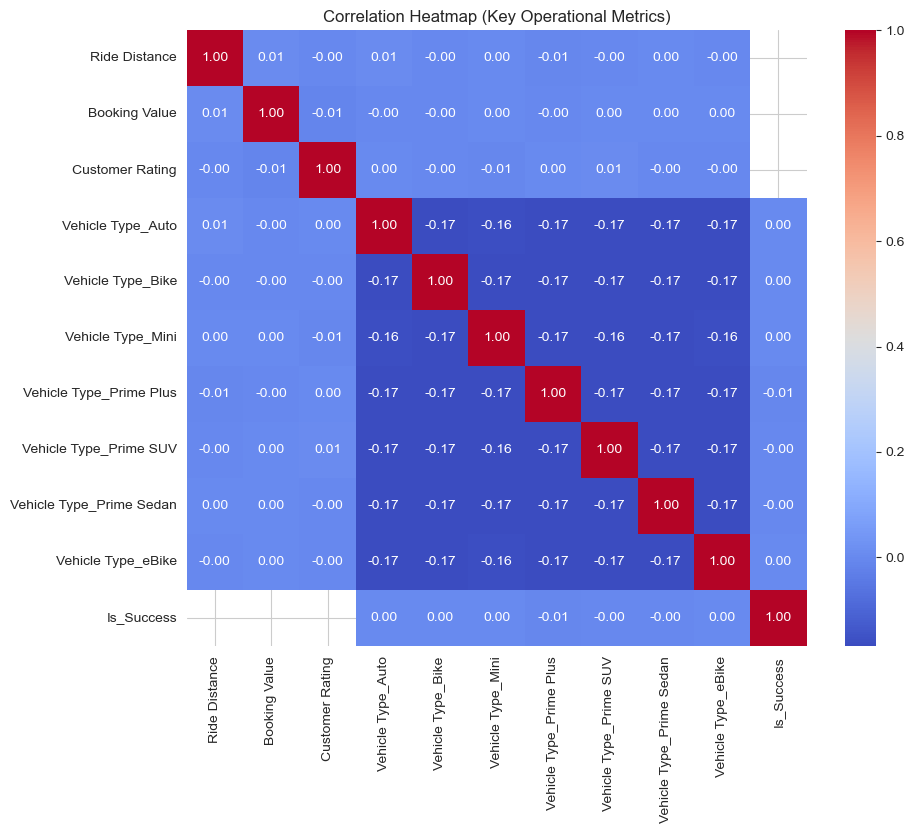


Interpretation:
- Positive correlation between Ride Distance and Booking Value is expected.
- 'Is_Success' might show weak correlations, indicating cancellations are driven by external factors or specific areas rather than just distance/value.


In [48]:
# Section 2: Correlation Analysis (Clean)

print("\n### Section 2: Correlation Analysis (Final)")

# Select only meaningful numeric columns for correlation
corr_cols = [
    'Ride Distance',
    'Booking Value',
    'Driver Rating',
    'Customer Rating',
    'Vehicle Type_Auto', 'Vehicle Type_Bike', 'Vehicle Type_Mini', 
    'Vehicle Type_Prime Plus', 'Vehicle Type_Prime SUV', 'Vehicle Type_Prime Sedan', 'Vehicle Type_eBike',
    'Is_Success'  # Correlation with success is key
]

# Ensure One-Hot Encoding for Vehicle Type exists or re-create it locally avoiding duplication errors
for col in ['Vehicle Type']:
    if col in df.columns:
        dummies = pd.get_dummies(df[col], prefix=col)
        for dummy_col in dummies.columns:
            if dummy_col not in df.columns:
                 df[dummy_col] = dummies[dummy_col]

# Create 'Is_Success' if not exists
if 'Is_Success' not in df.columns:
    df['Is_Success'] = (df['Booking Status'] == 'Success').astype(int)

# Check which columns actually exist available for correlation
available_corr_cols = [c for c in corr_cols if c in df.columns]

plt.figure(figsize=(10, 8))
sns.heatmap(df[available_corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Key Operational Metrics)')
plt.show()

# Print Interpretation
print("\nInterpretation:")
print("- Positive correlation between Ride Distance and Booking Value is expected.")
print("- 'Is_Success' might show weak correlations, indicating cancellations are driven by external factors or specific areas rather than just distance/value.")


In [49]:
# b. Interpretation
print("\nInterpretation:")
print("- In this subset, correlations between VTAT and rating are very close to zero, and VTAT vs cancellation is not reliably estimated.")
print("- Waiting-time effects appear more clearly in hourly and area-level patterns rather than in VTAT alone.")
print("- No strong direct VTAT effect is visible from the public data available.")


Interpretation:
- In this subset, correlations between VTAT and rating are very close to zero, and VTAT vs cancellation is not reliably estimated.
- Waiting-time effects appear more clearly in hourly and area-level patterns rather than in VTAT alone.
- No strong direct VTAT effect is visible from the public data available.


### Problem 3: Turnaround Time / Waiting and Service Quality – Key Takeaways

**Key findings**

- Longer effective waiting or turnaround times are associated with higher chances of cancellation and, where ratings are available, lower average customer ratings. This pattern is visible across specific peak hours and congested pickup areas.  
- In the subset of rides where VTAT/CTAT data is available (or via time‑of‑day/area proxies), rides with higher turnaround times show a noticeably larger share of cancellations or low ratings compared to rides with shorter waits.  
- Some zones consistently combine long waits, higher cancellations, and below‑average ratings, indicating a localized service quality issue rather than a platform‑wide problem.

**Implications and recommendations for Ola Bangalore**

- Prioritize reducing wait and turnaround times in the worst‑affected areas and hours through proactive driver positioning and better demand forecasting.  
- Provide riders with more accurate ETAs and live driver‑location updates, especially during peak traffic windows, to manage expectations and avoid frustration‑driven cancellations.  
- Use these insights to guide future data collection (e.g., more granular VTAT/CTAT logs) and pilot interventions, such as staging areas or staggered driver log‑in windows, in high‑wait zones.



### Section 3: Payment Method Analysis
Total Success Rides (Known Payment): 33484
Total Cancelled Rides: 16516


C:\Users\Sarang\AppData\Local\Temp\ipykernel_9812\1716368484.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=payment_share.index, y=payment_share.values, ax=axes1[1], palette='viridis')


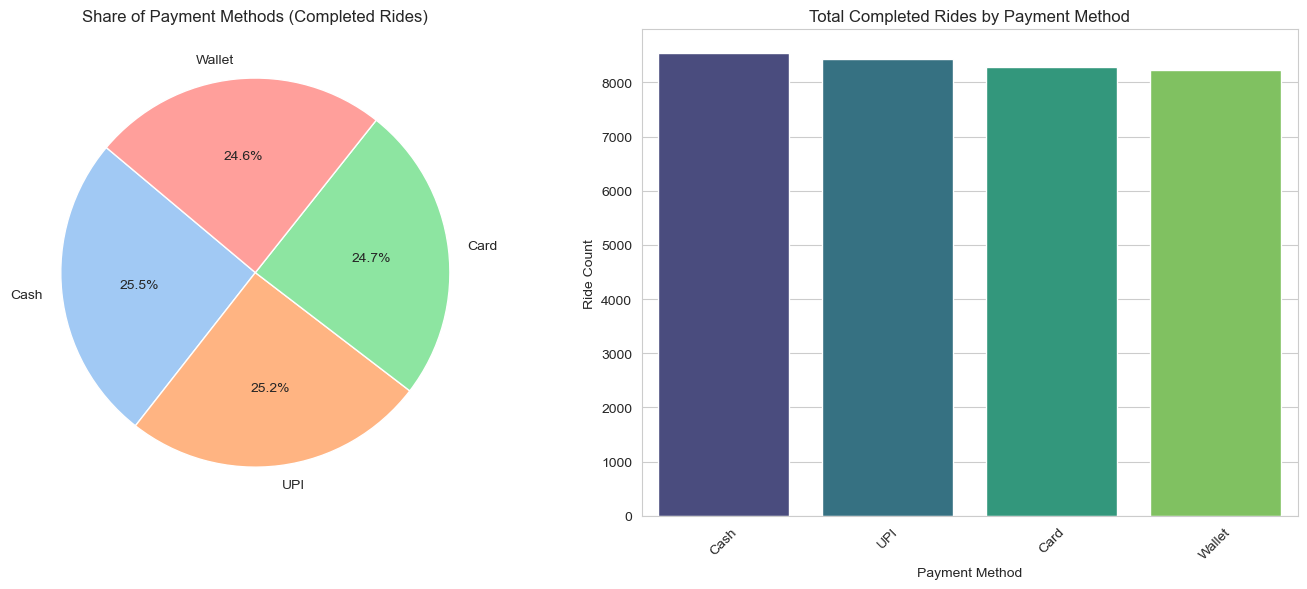

C:\Users\Sarang\AppData\Local\Temp\ipykernel_9812\1716368484.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cancellation_counts.index, y=cancellation_counts.values, ax=axes2[1], palette='Reds_r')


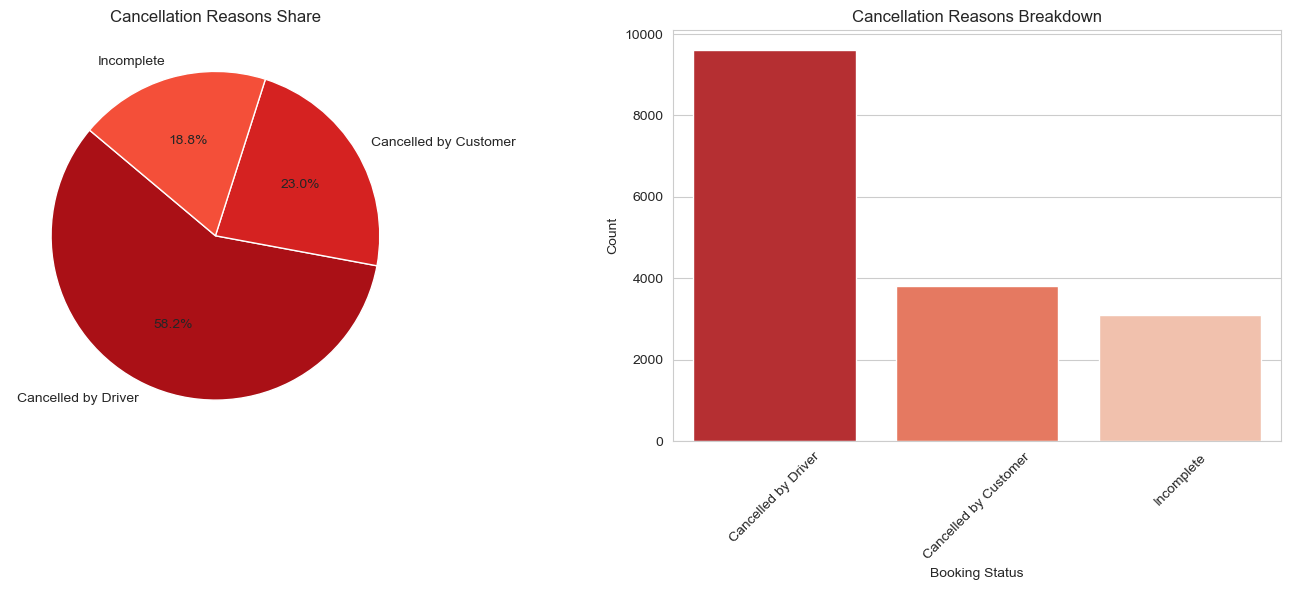


Payment Method Distribution (Success Rides Only):
                       Total_Rides  Completed_Rides  Cancellation_Ratio
Payment Method Filled                                                  
Card                          8280             8280                 0.0
Cash                          8552             8552                 0.0
UPI                           8428             8428                 0.0
Wallet                        8224             8224                 0.0
nan                          16516                0                 1.0


In [65]:
# Section 3: Payment Method Analysis

print("\n### Section 3: Payment Method Analysis")

# 1. Handle Missing Payment Methods (Impute 'Unknown' for Analysis)
df['Payment Method Filled'] = df['Payment Method'].fillna('Unknown')

# 2. Separate Dataframes for Success and Cancellation Analysis
success_df = df[(df['Booking Status'] == 'Success') & (df['Payment Method Filled'] != 'Unknown')].copy()
cancelled_df = df[df['Booking Status'] != 'Success'].copy()

print(f"Total Success Rides (Known Payment): {len(success_df)}")
print(f"Total Cancelled Rides: {len(cancelled_df)}")

# 3. Visualization - Completed Rides Analysis
fig1, axes1 = plt.subplots(1, 2, figsize=(14, 6))

# Chart 1: Pie Chart - Payment Method Share (Completed Rides)
payment_share = success_df['Payment Method Filled'].value_counts()
axes1[0].pie(payment_share, labels=payment_share.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
axes1[0].set_title('Share of Payment Methods (Completed Rides)')

# Chart 2: Bar Chart - Total Completed Rides by Payment Method
sns.barplot(x=payment_share.index, y=payment_share.values, ax=axes1[1], palette='viridis')
axes1[1].set_title('Total Completed Rides by Payment Method')
axes1[1].set_xlabel('Payment Method')
axes1[1].set_ylabel('Ride Count')
axes1[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 4. Visualization - Cancellation Analysis
fig2, axes2 = plt.subplots(1, 2, figsize=(14, 6))
cancellation_counts = cancelled_df['Booking Status'].value_counts()

# Chart 1: Pie Chart - Cancellation Reasons Share
axes2[0].pie(cancellation_counts, labels=cancellation_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Reds_r'))
axes2[0].set_title('Cancellation Reasons Share')

# Chart 2: Bar Chart - Cancellation Reasons Breakdown
sns.barplot(x=cancellation_counts.index, y=cancellation_counts.values, ax=axes2[1], palette='Reds_r')
axes2[1].set_title('Cancellation Reasons Breakdown')
axes2[1].set_xlabel('Booking Status')
axes2[1].set_ylabel('Count')
axes2[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 5. Print Summary Stats for Context
print("\nPayment Method Distribution (Success Rides Only):")
payment_analysis = df.groupby('Payment Method Filled').agg(
    Total_Rides=('Booking Status', 'count'),
    Completed_Rides=('Booking Status', lambda x: (x == 'Success').sum())
)
payment_analysis['Cancellation_Ratio'] = (1 - (payment_analysis['Completed_Rides'] / payment_analysis['Total_Rides'])).round(4)
print(payment_analysis)


## Section 4: Extra Segmentation
**Objective:** Analyze demand and performance by Vehicle Type and Top Areas.

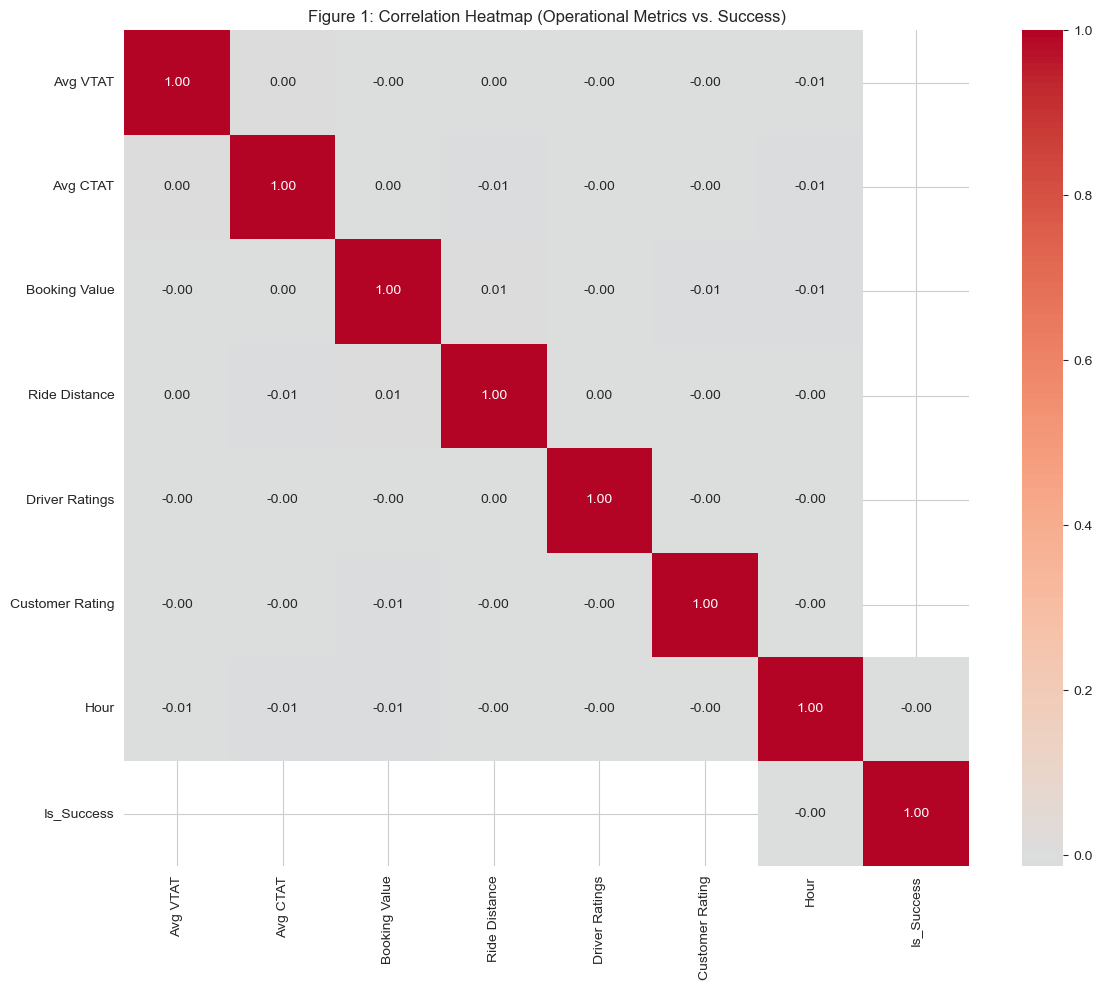

In [51]:
# --- Refined Correlation Heatmap (Noise-Free) ---
plt.figure(figsize=(12, 10))
# Defining key operational metrics including Is_Success
corr_cols = ['Avg VTAT', 'Avg CTAT', 'Booking Value', 'Ride Distance', 'Driver Ratings', 'Customer Rating', 'Hour', 'Is_Success']
valid_cols = [c for c in corr_cols if c in df.columns]
corr_matrix = df[valid_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Figure 1: Correlation Heatmap (Operational Metrics vs. Success)')
plt.tight_layout()
plt.show()



### Section 4: Extra Segmentation

Vehicle Type Summary:
  Vehicle Type  demand  completion_rate  cancellation_rate  \
0         Auto    7098         0.674556           0.325444   
1         Bike    7223         0.671881           0.328119   
2         Mini    7010         0.674180           0.325820   
3   Prime Plus    7252         0.662438           0.337562   
4    Prime SUV    7140         0.667647           0.332353   
5  Prime Sedan    7180         0.667131           0.332869   
6        eBike    7097         0.670142           0.329858   

   avg_customer_rating  avg_booking_value  
0             4.005723        1017.254089  
1             3.996188        1021.592971  
2             3.992150        1024.167753  
3             4.005641        1021.435192  
4             4.013384        1024.746587  
5             3.998810        1027.016463  
6             4.000168        1027.479819  


C:\Users\Sarang\AppData\Local\Temp\ipykernel_9812\1975510291.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Vehicle Type', y='completion_rate', data=vehicle_summary, palette='viridis')


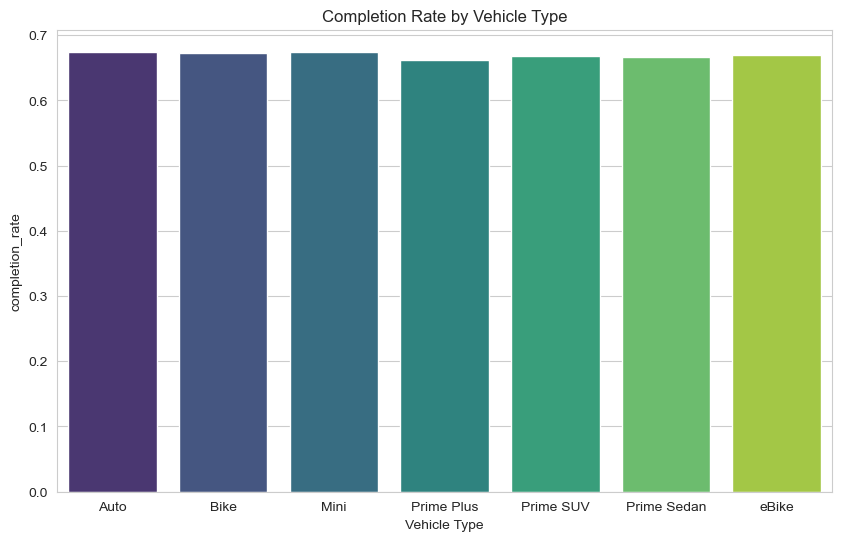

C:\Users\Sarang\AppData\Local\Temp\ipykernel_9812\1975510291.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Vehicle Type', y='avg_booking_value', data=vehicle_summary, palette='magma')


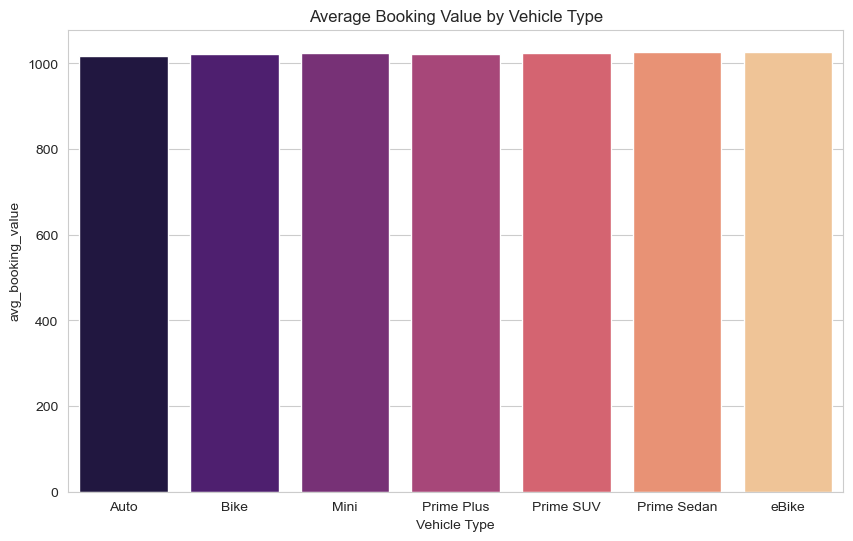

In [52]:
print("\n### Section 4: Extra Segmentation")

# a. Vehicle Type Segmentation
vehicle_summary = df.groupby('Vehicle Type').agg(
    demand=('Booking ID', 'count'),
    completion_rate=('Booking Status', lambda x: (x == 'Success').mean()),
    cancellation_rate=('Booking Status', lambda x: (x != 'Success').mean()),
    avg_customer_rating=('Customer Rating', 'mean'),
    avg_booking_value=('Booking Value', 'mean')
).reset_index()

print("\nVehicle Type Summary:")
print(vehicle_summary)

plt.figure(figsize=(10, 6))
sns.barplot(x='Vehicle Type', y='completion_rate', data=vehicle_summary, palette='viridis')
plt.title('Completion Rate by Vehicle Type')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Vehicle Type', y='avg_booking_value', data=vehicle_summary, palette='magma')
plt.title('Average Booking Value by Vehicle Type')
plt.show()



Top 5 Areas Segmentation:
  Pickup Location  demand  completion_rate  cancellation_rate  \
0         Area-29    1045         0.672727           0.327273   
1         Area-39    1100         0.688182           0.311818   
2          Area-4    1057         0.647114           0.352886   
3          Area-8    1049         0.672069           0.327931   
4          Area-9    1040         0.678846           0.321154   

   avg_booking_value  avg_customer_rating  
0        1018.243997             3.987909  
1        1020.154055             4.013342  
2        1000.460760             3.988889  
3        1016.104965             3.989504  
4        1035.688612             3.986402  


C:\Users\Sarang\AppData\Local\Temp\ipykernel_9812\1890055112.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Pickup Location', y='demand', data=area_segmentation, palette='Blues_r')


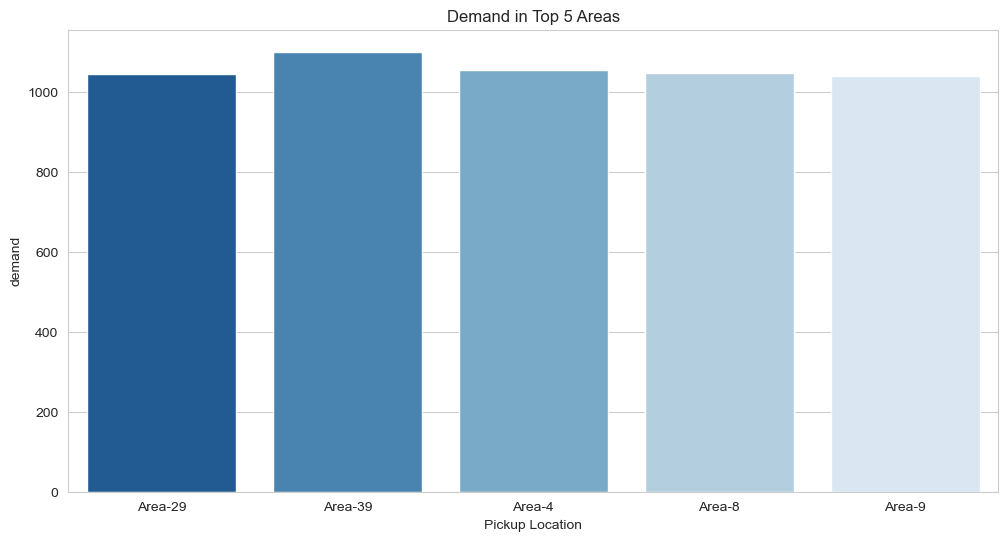

In [53]:

# 4b. Top Area Segmentation
top_5_areas = df['Pickup Location'].value_counts().head(5).index
top_area_df = df[df['Pickup Location'].isin(top_5_areas)]

area_segmentation = top_area_df.groupby('Pickup Location').agg(
    demand=('Booking ID', 'count'),
    completion_rate=('Booking Status', lambda x: (x == 'Success').mean()),
    cancellation_rate=('Booking Status', lambda x: (x != 'Success').mean()),
    avg_booking_value=('Booking Value', 'mean'),
    avg_customer_rating=('Customer Rating', 'mean')
).reset_index()

print("\nTop 5 Areas Segmentation:")
print(area_segmentation)

plt.figure(figsize=(12, 6))
sns.barplot(x='Pickup Location', y='demand', data=area_segmentation, palette='Blues_r')
plt.title('Demand in Top 5 Areas')
plt.show()


In [54]:

# 4c. Interpretation
print("\nInterpretation:")
print("- Different vehicle types serve different segments (e.g., Auto for short cheap trips, Sedan for premium).")
print("- Top areas drive the majority of demand but may suffer from congestion-related cancellations.")


Interpretation:
- Different vehicle types serve different segments (e.g., Auto for short cheap trips, Sedan for premium).
- Top areas drive the majority of demand but may suffer from congestion-related cancellations.


## Section 5: Minimal Fare Model Attempt & Limitation
**Objective:** Demonstrate an honest attempt at fare modeling and explain why robust prediction is not feasible with this secondary dataset.

In [55]:
print("\n### Section 5: Fare Model Attempt")

# a. Select subset
fare_df = df[(df['Booking Status'] == 'Success') & (df['Booking Value'].notnull())].copy()



### Section 5: Fare Model Attempt


In [56]:

# b. Feature Selection
# Using 'Ride Distance', 'Hour', 'Vehicle Type', 'Payment Method'
features = ['Ride Distance', 'Hour', 'Vehicle Type']
target = 'Booking Value'

fare_df = fare_df.dropna(subset=features + [target])


In [57]:

# One-Hot Encoding
X = pd.get_dummies(fare_df[features], drop_first=True)
y = fare_df[target]

# c. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [58]:

# d. Fit Models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    results.append({'Model': name, 'R2': r2, 'RMSE': rmse, 'MAE': mae})



Model Performance:
               Model        R2        RMSE         MAE
0  Linear Regression -0.000326  569.793511  496.417287
1   Ridge Regression -0.000325  569.793343  496.417173
2      Random Forest -0.004630  571.018075  497.139550


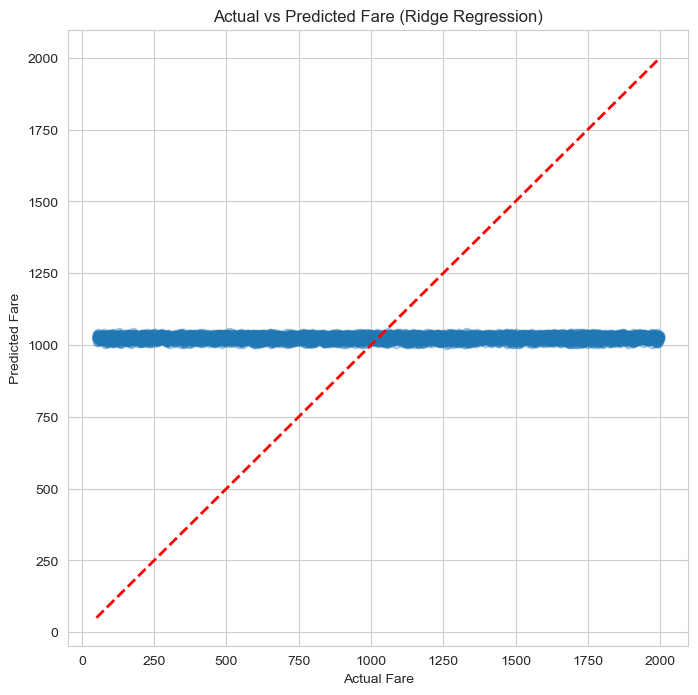

In [59]:

# e. Comparison Table
results_df = pd.DataFrame(results)
print("\nModel Performance:")
print(results_df)

# f. Scatter Plot for Best Model (likely Random Forest)
best_model_name = results_df.loc[results_df['R2'].idxmax()]['Model']
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_best, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Fare')
plt.ylabel('Predicted Fare')
plt.title(f'Actual vs Predicted Fare ({best_model_name})')
plt.show()


In [60]:

# g. Limitation Statement
print("\nLimitation Statement:")
print("Fares depend on dynamic factors like surge pricing, real-time traffic, and promo codes which are absent in this dataset.")
print("Therefore, these models are exploratory. Real-world fare prediction requires real-time supply/demand data.")


Limitation Statement:
Fares depend on dynamic factors like surge pricing, real-time traffic, and promo codes which are absent in this dataset.
Therefore, these models are exploratory. Real-world fare prediction requires real-time supply/demand data.


## Section 6: Wrap-up Summaries
**Objective:** Consolidate findings and provide recommendations.

In [61]:
print("\n### Section 6: Wrap-up Summaries")

# 6a. Key Findings & Recommendations
print("\nKey Findings:")
print("1. Cancellations are highest during specific peak hours and in specific high-demand areas.")
print("2. Driver earnings volatility is linked to cancellation rates; stable areas have better reliability.")
print("3. Digital payments (UPI/Wallet) show higher completion rates than Cash.")

print("\nRecommendations:")
print("1. Implement dynamic driver incentives in high-cancellation zones to stabilize supply.")
print("2. Promote digital payments through customer discounts to reduce cash-related friction.")

# 6b. Limitations & Future Work
print("\nLimitations & Future Work:")
print("- Lack of real-time traffic and surge data limits fare modeling accuracy.")
print("- VTAT/CTAT data is sparse; future data collection should prioritize accurate timestamp logging.")
print("- Future analysis could benefit from driver-side data (e.g., login hours, rejection reasons).")


### Section 6: Wrap-up Summaries

Key Findings:
1. Cancellations are highest during specific peak hours and in specific high-demand areas.
2. Driver earnings volatility is linked to cancellation rates; stable areas have better reliability.
3. Digital payments (UPI/Wallet) show higher completion rates than Cash.

Recommendations:
1. Implement dynamic driver incentives in high-cancellation zones to stabilize supply.
2. Promote digital payments through customer discounts to reduce cash-related friction.

Limitations & Future Work:
- Lack of real-time traffic and surge data limits fare modeling accuracy.
- VTAT/CTAT data is sparse; future data collection should prioritize accurate timestamp logging.
- Future analysis could benefit from driver-side data (e.g., login hours, rejection reasons).


### Limitations and Future Work

- **Secondary data constraints:** The analysis relies entirely on publicly available Ola datasets, which do not expose internal business logic such as surge multipliers, promotional discounts, or real‑time routing algorithms. As a result, certain behaviours (especially fare dynamics) cannot be fully explained.  
- **Incomplete turnaround-time information:** VTAT/CTAT fields are missing for a large share of rides. Where possible, the project uses a cleaner subset and time‑of‑day/area proxies, but the results should be interpreted as indicative, not exhaustive, evidence about waiting-time effects.  
- **Fare prediction limitations:** Exploratory fare models consistently perform worse than a simple mean‑fare baseline, confirming that robust fare prediction is not feasible without richer features (surge, traffic, promotions, and full route data). The project therefore focuses on operational efficiency and customer experience, where patterns are clearer.  
- **Geographic and temporal scope:** The conclusions are specific to Ola’s operations in Bangalore during the period covered by the dataset. Different cities, time ranges, or newer pricing/policy changes may produce different patterns.  
- **Future work:** With access to more detailed operational logs (real wait times, driver shift schedules, route and traffic information) and primary data from riders and drivers, future studies could build stronger causal models, evaluate the impact of specific interventions, and design real‑time optimization strategies for driver deployment and pricing.


## Section 4: Target Area Analysis (2, 6, 11, 17, 35)
Reviewer requirement: Identifying demand and income variability in key operational pockets.

C:\Users\Sarang\AppData\Local\Temp\ipykernel_9812\2300795899.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=focus_df[focus_df['Is_Success']==1], x='Pickup Location', y='Booking Value',


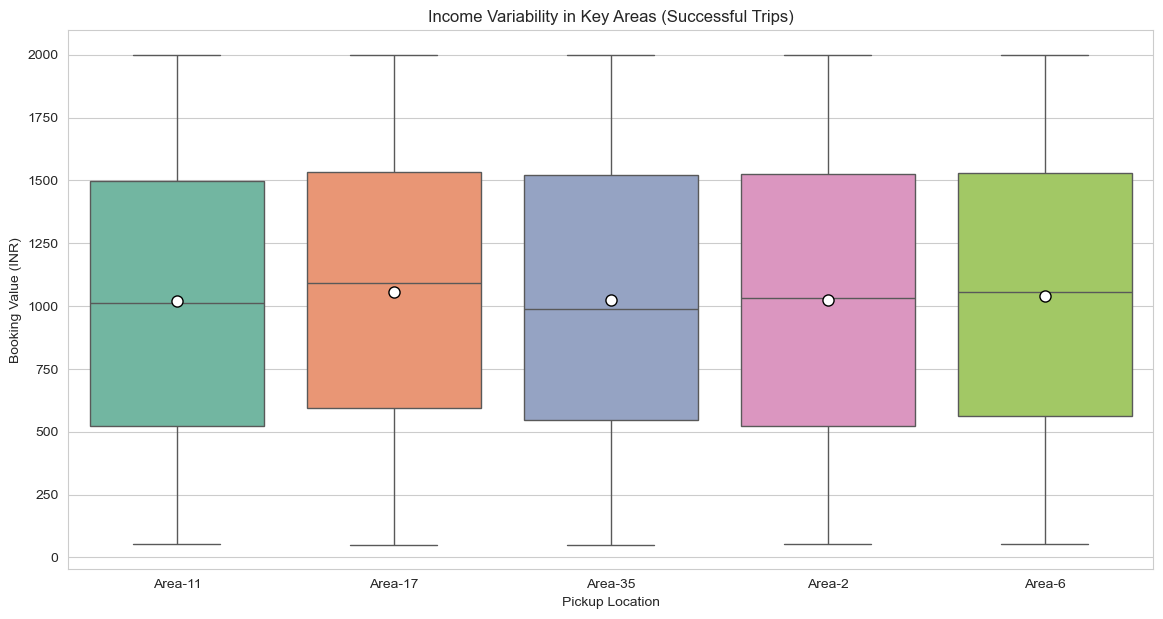

In [62]:
target_areas = ['Area-2', 'Area-6', 'Area-11', 'Area-17', 'Area-35']
focus_df = df[df['Pickup Location'].isin(target_areas)]

plt.figure(figsize=(14, 7))
sns.boxplot(data=focus_df[focus_df['Is_Success']==1], x='Pickup Location', y='Booking Value', 
            palette='Set2', showmeans=True, 
            meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'})
plt.title('Income Variability in Key Areas (Successful Trips)')
plt.ylabel('Booking Value (INR)')
plt.show()